# Varol Twitter data Investigation
## CSCE 670 Spring 2018, Course Project
### By: Rose Lin (826009602)

This notebook serves as the main playground for the [Varol](https://botometer.iuni.iu.edu/bot-repository/datasets.html) dataset.

## Load the user and tweet data

The original Varol dataset only provides 2,573 user IDs that are marked as spam (1) or non-spam (0). We have queried the offical [Twitter API](https://developer.twitter.com/en/docs) to collect account data. For each of the unsuspended account, we also crawled the 20 latest tweets. Unfortunately, due to the time latency between the release date of the dataset and access time, some accounts were already removed by Twitter or simply deactivated by the user. Below provides some basic statistics about the user and tweet data.

In [2]:
#Loading the user and the tweet data
import pandas as pd
import os
from datetime import date
cwd = os.getcwd()

print "Loading the user data..."
user = pd.read_csv(cwd+"/user_varol.csv",sep=',',header='infer')
user['crawled_at'] = date(2016,4,30)
# drop some features to match with cresci data
features_to_drop = ['is_translation_enabled', 'media_count', 'has_extended_profile', 'profile_location', 'withheld_in_countries', 'followed_by', 'business_profile_state', 'has_custom_timelines', 'can_media_tag', 'id_str', 'translator_type', 'normal_followers_count', 'fast_followers_count']
user = user.drop(features_to_drop, axis=1)
print "Loading the additional spam data..."
addi_spam = pd.read_csv(cwd+"/Sampled_spam_cresci.csv",sep=',',header='infer')
user = pd.concat([user, addi_spam], ignore_index=True)
print "Number of users:",user.id.nunique()
print "Number of spammers:",len(user[user.user_type == 1])
print "Number of legitmate users:",len(user[user.user_type == 0])

print "Loading the tweet data..."
tweet = pd.read_csv(cwd+"/2100-spam-ham-tweet-04032018.csv",sep=',',header='infer')
print "Number of tweets:",tweet.id.nunique()
print "Number of tweets generated by spammers:",len(tweet[tweet.user_type == 1])
print "Number of tweets generated by legitmate users:",len(tweet[tweet.user_type == 0])

Loading the user data...
Loading the additional spam data...
Number of users: 3157
Number of spammers: 1650
Number of legitmate users: 1650
Loading the tweet data...
Number of tweets: 42692
Number of tweets generated by spammers: 13817
Number of tweets generated by legitmate users: 28876


<!--- Looks like we have more normal users than the spammers... so we will need to perform some sort of sampling to make the ratio between the spammer and the normal users class to be 1:1 (otherwise the model will be horribly skewed towards non-spammers!). Oversampling on spammers is preferred in this case!

Some helpful links that I've read:
* [The Right Way to Oversample in Predictive Modeling](https://beckernick.github.io/oversampling-modeling/) - the authors claims that oversampling should be done on **the training set only**, otherwise it will kill your whole data.
* [Over-sampling guide for imbalanced-learn package](http://contrib.scikit-learn.org/imbalanced-learn/stable/over_sampling.html) - an easy to follow, hands-on guide on oversampling techniques available in the imbalanced-learn package. Oversampling could be done through the naive random way (randomly sampling with replacement the current available samples), or SMOTE/ADASYN. There are some tradeoffs so better choose the method wisely!

But before the game begins... better visualize the original data to get a sense of how spammers and legitimate users are distributed, as well as shedding light on what kind of features we should select in the final model. (Yeah, feature engineering does matter. I acknowledge that.) -->

We were able to have a roughly 1:1 ratio for the user data thanks to the additional cresci dataset. As for tweets, we will mainly use cresci for analysis, but also explore possibilities here.

## Visualization

The goal of this part is to visualize selected features to see if they are informative enough to distinguish the two classes, as well as to get a sense on how the data is distributed. (Plus it looks good on our poster.)

### Account features

We will start off with the *favorite_count* feature, which identifies how many tweets a user has liked in total.

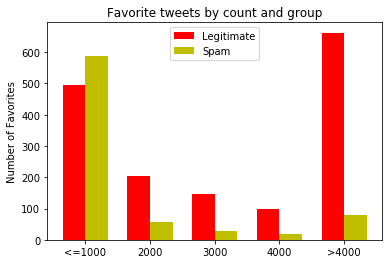

In [27]:
# source: https://matplotlib.org/examples/api/barchart_demo.html
import matplotlib.pyplot as plt
import numpy as np

N=5
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

bins = [0,1000,2000,3000,4000,float("inf")]

leg_fav = pd.cut(user[(user['user_type'] == 0)]['favourites_count'],bins=bins).value_counts(sort=False)
spam_fav = pd.cut(user[(user['user_type'] == 1)]['favourites_count'],bins=bins).value_counts(sort=False)

#print leg_fav
#print spam_fav

fig, ax = plt.subplots()
rects1 = ax.bar(ind, leg_fav, width, color='r')
rects2 = ax.bar(ind + width, spam_fav, width, color='y')

ax.set_ylabel('Number of Favorites')
ax.set_title('Favorite tweets by count and group')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('<=1000', '2000', '3000', '4000', '>4000'))

ax.legend((rects1[0], rects2[0]), ('Legitimate', 'Spam'))

plt.show()

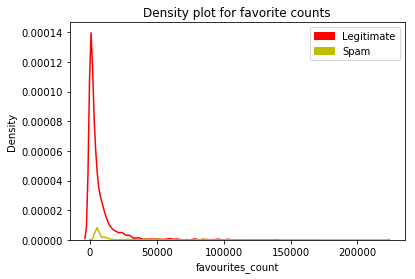

In [28]:
# Just another way to visualize
import seaborn as sns
import matplotlib.patches as mpatches

leg_favc = user[(user['user_type'] == 0)]['favourites_count']
spam_favc = user[(user['user_type'] == 1)]['favourites_count']

fig, ax = plt.subplots()
rects1 = sns.distplot(leg_favc, hist=False,color='r')
rects2 = sns.distplot(spam_favc, hist=False,color='y')
ax.set_ylabel('Density')
ax.set_title('Density plot for favorite counts')
red_patch = mpatches.Patch(color='r', label='Legitimate')
yellow_patch = mpatches.Patch(color='y', label='Spam')
plt.legend(handles=[red_patch,yellow_patch])
plt.show()

Looks like *favourites_count* is a feature that we can utilize as most of the legitimate users favorite more tweets than spammers do. How about the follower/following ratio? That should be low for spammers as per inituition.

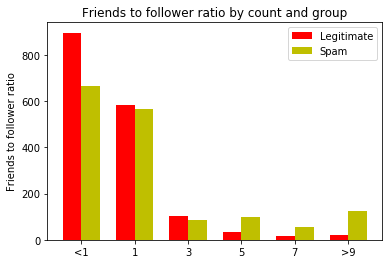

In [29]:
#legfo = user[(user['user_type'] == 0)].groupby(['followers_count','friends_count']).size()
#print legfo
bins2 = [-float("inf"),1,3,5,7,9,float("inf")]
leg_fo_ratio = pd.cut(user[(user['user_type'] == 0)]['friends_count']/user[(user['user_type'] == 0)]['followers_count'],bins=bins2).value_counts(sort=False)
spam_fo_ratio = pd.cut(user[(user['user_type'] == 1)]['friends_count']/user[(user['user_type'] == 1)]['followers_count'],bins=bins2).value_counts(sort=False)
#print leg_fo_ratio
#print spam_fo_ratio

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(6), leg_fo_ratio, width, color='r')
rects2 = ax.bar(np.arange(6) + width, spam_fo_ratio, width, color='y')

ax.set_ylabel('Friends to follower ratio')
ax.set_title('Friends to follower ratio by count and group')
ax.set_xticks(np.arange(6) + width / 2)
ax.set_xticklabels(('<1', '1', '3', '5', '7','>9'))

ax.legend((rects1[0], rects2[0]), ('Legitimate', 'Spam'))

plt.show()

Clearly, spammers tend to have a higher friends-to-follower ratio (that is, following >> followers) so this might be used as a useful metric. Most legitimate users have low friends-to-follower ratio instead. How about *statuses_count*?

Legitimate users status count statistics:
count      1650.000000
mean      13777.139394
std       22012.988088
min           1.000000
25%        2555.000000
50%        6301.500000
75%       15868.000000
max      301252.000000
Name: statuses_count, dtype: float64

Spam users status count statistics:
count      1650.000000
mean       8015.832727
std       20000.465777
min           0.000000
25%         188.250000
50%        1384.500000
75%        8952.500000
max      323618.000000
Name: statuses_count, dtype: float64


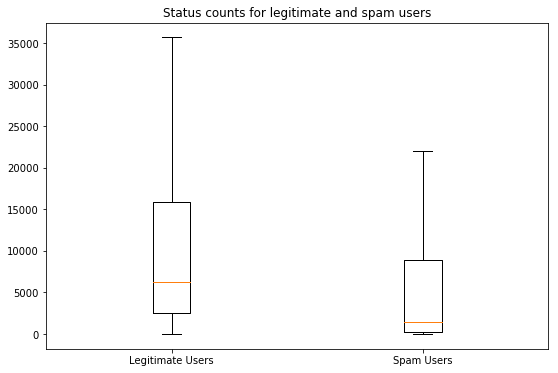

In [30]:
# get the summary statistics on status count
print("Legitimate users status count statistics:")
print(user[(user['user_type'] == 0)]['statuses_count'].describe())
print("")
print("Spam users status count statistics:")
print(user[(user['user_type'] == 1)]['statuses_count'].describe())

# Boxplot
# Source:
import matplotlib as mpl
import matplotlib.pyplot as plt
leg_tweet_count = user[(user['user_type'] == 0)]['statuses_count']
spam_tweet_count = user[(user['user_type'] == 1)]['statuses_count']
data_to_plot = [leg_tweet_count,spam_tweet_count]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
# hide outliers - we will need to handle them but they make the graph really skewed and hard to read
ax.boxplot(data_to_plot, showfliers=False, sym='')
ax.set_title('Status counts for legitimate and spam users')

## Custom x-axis labels
ax.set_xticklabels(['Legitimate Users', 'Spam Users'])

plt.show()

Clearly, the box plot above shows that the variance for legitimate users is greater than spam users. Medians for the two groups are rougly the same, but the interquartile ranage is clearly larger for legitimate users than spam users. This is an interesting feature to explore as well. (For more info about how to interpret a box plot, check out [here](https://www.wellbeingatschool.org.nz/information-sheet/understanding-and-interpreting-box-plots)).

Next, we believe that spammers are usually in hurry so won't change the default profile image. The *default_profile* attribute is not used here because, based on heuristics, most users do not have the motivation to change the theme or background of their profiles. But the data will tell us if our assumptions are correct or not! :)

Looking at the default profile image distribution now...
Legitimate users:
default_profile_image
False    1638
True       12
dtype: int64
Spam users:
default_profile_image
False    671
True      79
         895
1.0        5
dtype: int64

Looking at the default profile distribution now...
Legitimate users:
default_profile
False    1035
True      615
dtype: int64
Spam users:
default_profile
False    360
True     390
         774
1.0      126
dtype: int64


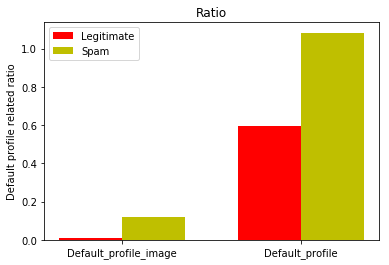

In [31]:
# group users by default_profile_image
print("Looking at the default profile image distribution now...")
leg_pi = user[(user['user_type'] == 0)].groupby(['default_profile_image']).size()
spam_pi = user[(user['user_type'] == 1)].groupby(['default_profile_image']).size()
print "Legitimate users:\n",leg_pi
print "Spam users:\n",spam_pi
# Also check through the default_profile
print("\nLooking at the default profile distribution now...")
leg_dp = user[(user['user_type'] == 0)].groupby(['default_profile']).size()
spam_dp = user[(user['user_type'] == 1)].groupby(['default_profile']).size()
print "Legitimate users:\n",leg_dp
print "Spam users:\n",spam_dp
# Let's get the ratio here and draw a bar plot!
from __future__ import division

leg_pi_ratio = leg_pi.get(True)/leg_pi.get(False)
spam_pi_ratio = spam_pi.get(True)/spam_pi.get(False)
leg_p_ratio = leg_dp.get(True)/leg_dp.get(False)
spam_p_ratio = spam_dp.get(True)/spam_dp.get(False)
leg_profile = [leg_pi_ratio, leg_p_ratio]
spam_profile = [spam_pi_ratio, spam_p_ratio]

fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(2), leg_profile, width, color='r')
rects2 = ax.bar(np.arange(2) + width, spam_profile, width, color='y')

ax.set_ylabel('Default profile related ratio')
ax.set_title('Ratio')
ax.set_xticks(np.arange(2) + width / 2)
ax.set_xticklabels(('Default_profile_image', 'Default_profile'))

ax.legend((rects1[0], rects2[0]), ('Legitimate', 'Spam'))

plt.show()

LOL, looks like *default_profile_image* and *default_profile* do help here. Now we will explore account ages. They're calculated based upon the *created_at* attribute up till the time when the data was collected (in April 2016; we use April 30, 2016 as the stop date). Also, account ages are based on days, not years.

In [32]:
# calculate account age in days
from datetime import date    
leg_age = pd.to_datetime(user[(user['user_type'] == 0)]['crawled_at'])-pd.to_datetime(user[(user['user_type'] == 0)]['created_at'])
spam_age = pd.to_datetime(user[(user['user_type'] == 1)]['crawled_at'])-pd.to_datetime(user[(user['user_type'] == 1)]['created_at'])
leg_age = leg_age.dt.days
spam_age = spam_age.dt.days
# print some summary statistics
print("Summary statistics for legitimate user account age:")
print(leg_age.describe())
print("\nSummary statistics for spam user account age:")
print(spam_age.describe())

bins = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500]

leg_age_group = pd.cut(leg_age,bins=bins).value_counts(sort=False)
spam_age_group = pd.cut(spam_age,bins=bins).value_counts(sort=False)

print leg_age_group
print spam_age_group

Summary statistics for legitimate user account age:
count    1650.000000
mean     1425.593939
std       744.137008
min       129.000000
25%       811.750000
50%      1439.000000
75%      1953.750000
max      3448.000000
dtype: float64

Summary statistics for spam user account age:
count    1650.000000
mean     1028.827879
std       864.047703
min        24.000000
25%       282.000000
50%       802.500000
75%      1728.750000
max      3094.000000
dtype: float64
(0, 500]        230
(500, 1000]     311
(1000, 1500]    325
(1500, 2000]    395
(2000, 2500]    223
(2500, 3000]    157
(3000, 3500]      9
dtype: int64
(0, 500]        603
(500, 1000]     396
(1000, 1500]    179
(1500, 2000]    139
(2000, 2500]    195
(2500, 3000]    135
(3000, 3500]      3
dtype: int64


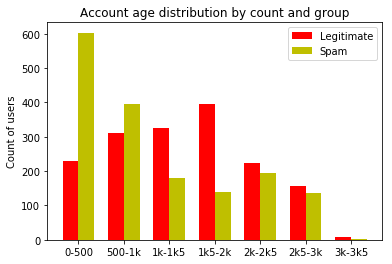

In [33]:
fig, ax = plt.subplots()
rects1 = ax.bar(np.arange(7), leg_age_group, width, color='r')
rects2 = ax.bar(np.arange(7) + width, spam_age_group, width, color='y')

width = 0.35 # so that labels won't block each other

ax.set_ylabel('Count of users')
ax.set_title('Account age distribution by count and group')
ax.set_xticks(np.arange(7) + width / 2)
ax.set_xticklabels(('0-500', '500-1k', '1k-1k5', '1k5-2k', '2k-2k5','2k5-3k','3k-3k5'))

ax.legend((rects1[0], rects2[0]), ('Legitimate', 'Spam'))

plt.show()

It seems that most of the spam accounts, though manage to mimic real users, hardly survived past 500 days. This seems to be an informative feature to include.

What about location? Is there anything interesting that we should care about?

TODO:
* *screen_name* and *name* deceiving? (This is more on the text analysis side)
* *description* length, as well as text (lexical analysis)

In [34]:
# get the location data
#print user[(user['user_type'] == 0)].location.describe()
#print user[(user['user_type'] == 1)].location.describe()
print("Legitimate users grouped by location:")
print user[(user['user_type'] == 0)].groupby(['location']).size()
print("")
print("Spam users grouped by location:")
print user[(user['user_type'] == 1)].groupby(['location']).size()

Legitimate users grouped by location:
location
\r\nİzmir                         1
                                  1
                                  1
  DMV                             1
 Cactus St Accra                  1
 Gloucestershire/London           1
 In My OWN Lane... Cali └A❤       1
#PlayLikeBray                     1
% melon                           1
'Tween Here & There               1
(Fav: RM & JIN)(Pron:They/Her)    1
//SFV //818 //VALLEY LIFE         1
08.04.2016                        1
100 S. Woodward Ave               1
101 Clarence St, Ottawa, On       1
11.12.15                          1
111111                            1
131095                            1
1900 Ursuline Ave ❗️              1
205 ✈️ 256                        1
221B Baker Street                 1
25/196                            1
252 ➡️ 919                        1
253, Washington                   1
408, AZ                           1
4114                              1
423              

A sneak peek into the location attribute shows that this field doesn't provide too much of information, as it can easily be manipulated by the user and not actually reflecting the authentic location. Thus, we will not consider it anymore.

Next, we would like to explore if there is any similarity between legitimate and spam users' screen_name (as well as name itself). Note that *screen_name* is a single string that has to be less than 15 characters in size. It is unique but subject to change. So we should still use *id_str* as a user identifier whenever possible.

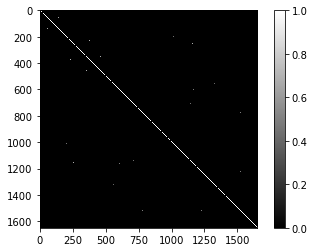

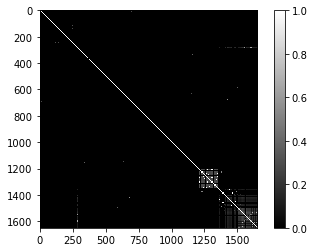

In [70]:
# start out with screen name
import re, string
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer

leg_sn = []
spam_sn = []
ps = PorterStemmer()

# lowercase everything, remove numbers and puncuation
for u in user[(user['user_type'] == 0)].screen_name.tolist():
    # remove all punctuations
    u = u.translate(None, string.punctuation)
    # casefolding
    u = u.lower()
    # remove numbers
    u = u.translate(None, string.digits)
    # no tokenization as screen_name might be weird
    #u = ps.stem(u)
    # add to the cleaned list
    leg_sn.append(u)
# do the same for spam
for u in user[(user['user_type'] == 1)].screen_name.tolist():
    # remove all punctuations
    u = u.translate(None, string.punctuation)
    # casefolding
    u = u.lower()
    # remove numbers
    u = u.translate(None, string.digits)
    # no tokenization as screen_name might be weird
    #u = ps.stem(u)
    # add to the cleaned list
    spam_sn.append(u)
    
# old friend TFIDF
tfidf_transformer = TfidfVectorizer()
cmap = plt.cm.gray
leg_n_tfidf = tfidf_transformer.fit_transform(user[(user['user_type'] == 0)].name.tolist())
plt.imshow((leg_n_tfidf * leg_n_tfidf.T).A, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show()
spam_n_tfidf = tfidf_transformer.fit_transform(user[(user['user_type'] == 1)].name.tolist())
plt.imshow((spam_n_tfidf * spam_n_tfidf.T).A, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show()

We will figure out how to do lexical analysis on screen_name and name eventually. There might be some correlation between them, or maybe not, as these two fields can be easily manipulated by users. Another thing of interest is the *description* field. Specifically, what is the length of it? Is there any word that shows repeatedly under different profiles? We will find out.

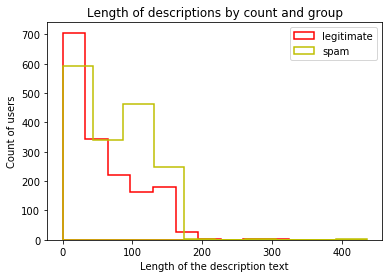

In [67]:
# check the length of the description field
leg_desp_len = []
for d in user[(user['user_type'] == 0)].description:
    if type(d) is float:
        leg_desp_len.append(0)
    else:
        leg_desp_len.append(len(d))
spam_desp_len = []
for d in user[(user['user_type'] == 1)].description:
    if type(d) is float:
        spam_desp_len.append(0)
    else:
        spam_desp_len.append(len(d))
# plot a histogram of the two list
fig, ax = plt.subplots()
ax.set_ylabel('Count of users')
ax.set_xlabel('Length of the description text')
ax.set_title('Length of descriptions by count and group')
ax.hist(leg_desp_len, 10, None, ec='r',fc='none', lw=1.5, histtype='stepfilled', label='legitimate')
ax.hist(spam_desp_len, 10, None, ec='y',fc='none', lw=1.5, histtype='stepfilled', label='spam')
ax.legend(loc='upper right')
plt.show()

Interesting enough, a large portion of spammers and legitimate users leave their descrptions empty. Nonetheless, a handful of spammers have their length of description texts longer than 100. This seems to be a feature to consider about. How about the similarity between texts? That is, can we say that legitimate or spammers tend to have similar profiles within their own groups?

TFIDF similarities between descriptions of legitimate users:


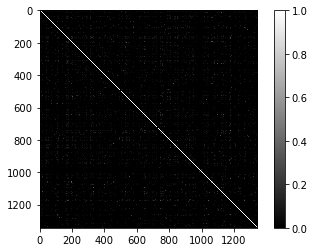

TFIDF similarities between descriptions of spammers:


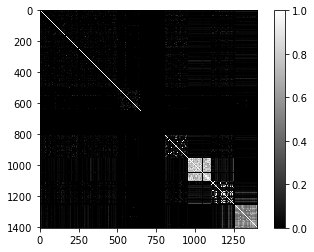

In [86]:
# Text analysis, traditional TFIDF
tfidf_transformer = TfidfVectorizer()
cmap = plt.cm.gray
leg_des_text = user[(user['user_type'] == 0)].description.tolist()
leg_des_text = [x for x in leg_des_text if str(x) != 'nan']
leg_des_text_cleaned = []
# do some processing here
# lowercase everything, remove numbers and puncuation
for d in leg_des_text:
    # remove all punctuations
    d = d.translate(None, string.punctuation)
    # casefolding
    d = d.lower()
    # remove numbers
    d = d.translate(None, string.digits)
    # remove non ascii characters
    d = re.sub(r'[^\x00-\x7f]',r'', d) 
    # no tokenization as screen_name might be weird
    #u = ps.stem(u)
    # substitute blank and \n
    d = d.replace("\n","")
    # add to the cleaned list
    if len(d) > 0:
        leg_des_text_cleaned.append(d)

leg_des_tfidf = tfidf_transformer.fit_transform(leg_des_text_cleaned)
print 'TFIDF similarities between descriptions of legitimate users:'
plt.imshow((leg_des_tfidf * leg_des_tfidf.T).A, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show()
# as for spam...
spam_des_text = user[(user['user_type'] == 1)].description.tolist()
spam_des_text = [x for x in spam_des_text if str(x) != 'nan']
spam_des_text_cleaned = []
# do some processing here
# lowercase everything, remove numbers and puncuation
for d in spam_des_text:
    # remove all punctuations
    d = d.translate(None, string.punctuation)
    # casefolding
    d = d.lower()
    # remove numbers
    d = d.translate(None, string.digits)
    # remove non ascii characters
    d = re.sub(r'[^\x00-\x7f]',r'', d) 
    # no tokenization as screen_name might be weird
    #u = ps.stem(u)
    # substitute blank and \n
    d = d.replace("\n","")
    # add to the cleaned list
    if len(d) > 0:
        spam_des_text_cleaned.append(d)

spam_des_tfidf = tfidf_transformer.fit_transform(spam_des_text_cleaned)
print 'TFIDF similarities between descriptions of spammers:'
plt.imshow((spam_des_tfidf * spam_des_tfidf.T).A, interpolation='nearest', cmap=cmap)
plt.colorbar()
plt.show()

Wow! Looks like spammers' descritpions are really different from legitimate users, who have a lot of variance and share little in common. 

In short, we have identified the following account-based features that we'd like to use in our detection tool:
* Count of favorite tweets
* Friends to follower ratio
* Total status count
* Default profile image and default profile ratios
* Account ages
* User name and screen_name (more exploration needed)
* Length of description and description text

We will move to visualize/analyze tweet-based features in the next section.

### Tweet-based features

We will first check to see if favorite count for each tweet varies. Our initial hypothesis is that most tweets were not favorited by large amount of people. The data will tell us if it's true!

Below are a list of tweet-based features that we would like to investigate:

* Favorite_count: Will a tweet from spammers gets more favorites than normal users?
* Same for retweet_count, quote_count, reply_count
* Source: There might be difference on what platform spammers/legitimate users choose to send their tweets from.
* In_reply_to …: If possible, we would like to see if our dataset contains clusters that might help us better identify spammers/normal users.

Legitimate users's tweets favorite count statistics:
count    28876.000000
mean         1.110126
std          8.041110
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        530.000000
Name: favorite_count, dtype: float64

Spam users's tweets favorite count statistics:
count    13817.000000
mean         1.155316
std         16.615615
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        563.000000
Name: favorite_count, dtype: float64


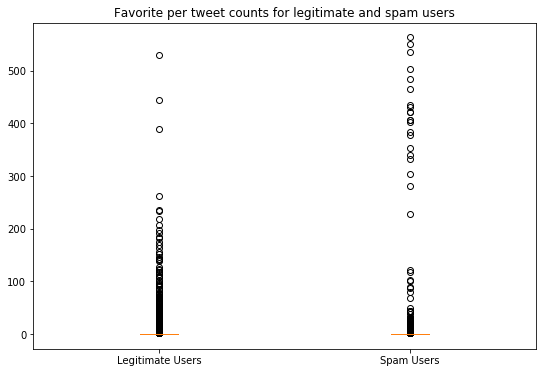

In [4]:
# get the summary statistics on status count
print("Legitimate users's tweets favorite count statistics:")
print(tweet[(tweet['user_type'] == 0)]['favorite_count'].describe())
print("")
print("Spam users's tweets favorite count statistics:")
print(tweet[(tweet['user_type'] == 1)]['favorite_count'].describe())

# Boxplot
# Source:
import matplotlib as mpl
import matplotlib.pyplot as plt
leg_fav_count = tweet[(tweet['user_type'] == 0)]['favorite_count']
spam_fav_count = tweet[(tweet['user_type'] == 1)]['favorite_count']
data_to_plot = [leg_fav_count,spam_fav_count]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
# hide outliers - we will need to handle them but they make the graph really skewed and hard to read
ax.boxplot(data_to_plot)
ax.set_title('Favorite per tweet counts for legitimate and spam users')

## Custom x-axis labels
ax.set_xticklabels(['Legitimate Users', 'Spam Users'])

plt.show()

So *favorite_count* per tweet doesn't seem to be a too informative feature to use, though there are a lot of outliers. (We will investigate them later) How about retweet_count, quote_count, and reply_count per tweet? We believe these won't be too distinguishable as well.

Legitimate users's tweets RT count statistics:
count    2.887600e+04
mean     7.297408e+03
std      3.786075e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+00
75%      2.150000e+02
max      3.627440e+06
Name: retweet_count, dtype: float64

Spam users's tweets RT count statistics:
count    1.381700e+04
mean     1.255661e+03
std      1.825525e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.000000e+00
max      1.710871e+06
Name: retweet_count, dtype: float64


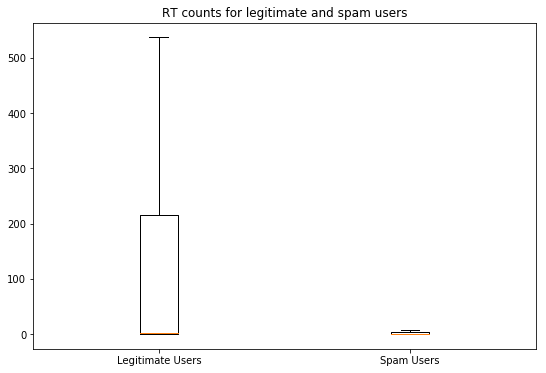

In [6]:
# Similar check on retweet_count
print("Legitimate users's tweets RT count statistics:")
print(tweet[(tweet['user_type'] == 0)]['retweet_count'].describe())
print("")
print("Spam users's tweets RT count statistics:")
print(tweet[(tweet['user_type'] == 1)]['retweet_count'].describe())

# Boxplot
# Source:
import matplotlib as mpl
import matplotlib.pyplot as plt
leg_rt_count = tweet[(tweet['user_type'] == 0)]['retweet_count']
spam_rt_count = tweet[(tweet['user_type'] == 1)]['retweet_count']
data_to_plot = [leg_rt_count,spam_rt_count]

# Create a figure instance
fig = plt.figure(1, figsize=(9, 6))

# Create an axes instance
ax = fig.add_subplot(111)

# Create the boxplot
# hide outliers - we will need to handle them but they make the graph really skewed and hard to read
ax.boxplot(data_to_plot, showfliers=False, sym='')
ax.set_title('RT counts for legitimate and spam users')

## Custom x-axis labels
ax.set_xticklabels(['Legitimate Users', 'Spam Users'])

plt.show()

Interesting enough, it looks like tweets from legitimate users are more likely to be retweeted than spammers. Though the medians are about the same, the whisker is much longer for normal users. Thus, this is a feature to consider.

Unfortunately, varol's dataset doesn't have the quoted_count and reply_count features. Next, we will visualize the source distribution.

In [18]:
# Check on source
# Preprocessing to remove HTML tags
from bs4 import BeautifulSoup
source_leg = []
source_spam = []
for src in tweet[(tweet['user_type'] == 0)]['source']:
    if not type(src) is float:
        source_leg.append(BeautifulSoup(src, "lxml").text)
for src in tweet[(tweet['user_type'] == 1)]['source']:
    if not type(src) is float:
        source_spam.append(BeautifulSoup(src, "lxml").text)

#tweet[(tweet['user_type'] == 1)]['source']

[(u'Twitter for iPhone', 14550), (u'Twitter for Android', 5952), (u'Twitter Web Client', 2642), (u'Facebook', 864), (u'Instagram', 785), (u'Twitter for iPad', 424), (u'Twitter Lite', 401), (u'TweetDeck', 316), (u'Twittascope', 208), (u'fllwrs', 196)]


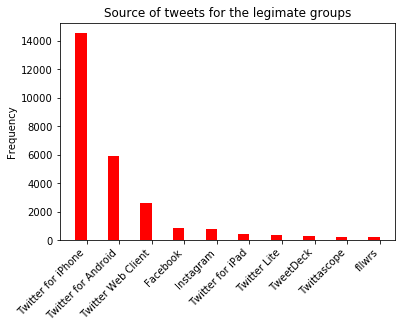

In [31]:
# Plot it!
import collections
import numpy as np
leg_src_count = collections.Counter(source_leg).most_common(10)

print leg_src_count

N=len(leg_src_count)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

bins = N

leg_src = [x[1] for x in leg_src_count]

fig, ax = plt.subplots()
rects1 = ax.bar(ind, leg_src, width, color='r')

ax.set_ylabel('Frequency')
ax.set_title('Source of tweets for the legimate groups')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([x[0] for x in leg_src_count],rotation = 45, ha="right")

plt.show()

[(u'Twitter Web Client', 2314), (u'Twitter for iPhone', 1899), (u'Twitter for Android', 1523), (u'Facebook', 1419), (u'Hootsuite', 655), (u'twitterfeed', 475), (u'TweetDeck', 439), (u'IFTTT', 338), (u'Instagram', 329), (u'ONE PIECE TREASURE CRUISE', 320)]


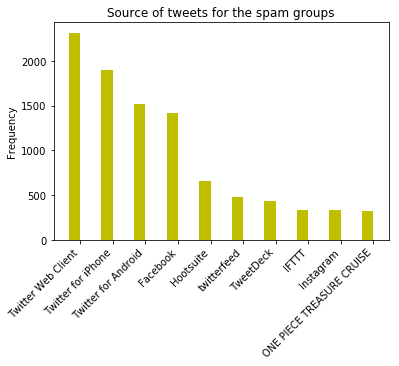

In [32]:
spam_src_count = collections.Counter(source_spam).most_common(10)

print spam_src_count

N=len(spam_src_count)
ind = np.arange(N)  # the x locations for the groups
width = 0.35       # the width of the bars

bins = N

spam_src = [x[1] for x in spam_src_count]

fig, ax = plt.subplots()
rects1 = ax.bar(ind, spam_src, width, color='y')

ax.set_ylabel('Frequency')
ax.set_title('Source of tweets for the spam groups')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels([x[0] for x in spam_src_count],rotation = 45, ha="right")

plt.show()

Looks like *source* is a bit different for the two groups but not entirely (as they both heavily tweeted from the web client and via iPhone/Android). Next, we'd like to explore the *in_reply_to_user_id_str* feature. Ideally, we can use this to build a user-user graph and identify potential spam clusters. Nonetheless, considering that we are going to build an online spam detector and the nature of Twitter, it's not realistic to actually implement this feature in real world (due to time constraints as well as limited information about the entire Twitter graph). That being said... we still prefer to take a look! :)

In [3]:
# Some summary statistics
print("Legitimate users's tweets in reply to user id statistics:")
print(tweet[(tweet['user_type'] == 0)]['in_reply_to_user_id'].describe())
print("")
print("Spam users's tweets in reply to user id statistics:")
print(tweet[(tweet['user_type'] == 1)]['in_reply_to_user_id'].describe())

# Use networkX to help with creating the graph
# Legitimate users
import networkx as nx

legu=nx.Graph()

for index, row in tweet[(tweet['user_type'] == 0)].iterrows():
    if row['in_reply_to_user_id'] != ' ' and len(row['in_reply_to_user_id'])>0:
        if row['id'] not in legu.nodes():
            legu.add_node(row['id'])
        if row['in_reply_to_user_id'] not in legu.nodes():
            legu.add_node(row['in_reply_to_user_id'])
        if legu.has_edge(row['id'], row['in_reply_to_user_id']):
            # we added this one before, just increase the weight by one
            legu[row['id']][row['in_reply_to_user_id']]['weight'] += 1
        else:
            # new edge. add with weight=1
            legu.add_edge(row['id'], row['in_reply_to_user_id'], weight=1)

#print("Nodes of graph: ")
#print(legu.nodes())
#print("Edges of graph: ")
#print(legu.edges())

A = nx.adjacency_matrix(legu)
print("")
print "Largest value in the user-user matrix (normal):",A.max()

Legitimate users's tweets in reply to user id statistics:
count     28876
unique     3658
top            
freq      23662
Name: in_reply_to_user_id, dtype: object

Spam users's tweets in reply to user id statistics:
count     13817
unique      581
top            
freq      12985
Name: in_reply_to_user_id, dtype: object

Largest value in the user-user matrix (normal): 1


In [44]:
# Spam users
import networkx as nx

spamu=nx.Graph()

for index, row in tweet[(tweet['user_type'] == 1)].iterrows():
    if row['in_reply_to_user_id'] != ' ' and len(row['in_reply_to_user_id'])>0:
        if row['id'] not in spamu.nodes():
            spamu.add_node(row['id'])
        if row['in_reply_to_user_id'] not in spamu.nodes():
            spamu.add_node(row['in_reply_to_user_id'])
        if spamu.has_edge(row['id'], row['in_reply_to_user_id']):
            # we added this one before, just increase the weight by one
            spamu[row['id']][row['in_reply_to_user_id']]['weight'] += 1
        else:
            # new edge. add with weight=1
            spamu.add_edge(row['id'], row['in_reply_to_user_id'], weight=1)

#print("Nodes of graph: ")
#print(legu.nodes())
#print("Edges of graph: ")
#print(legu.edges())

A = nx.adjacency_matrix(spamu)
print "Largest value in the user-user matrix (spam):",A.max()

Largest value in the user-user matrix (spam): 1


Hmm, so looks like our user-user matrix for both spammers and normal users are sparse, and we cannot find one or more users that either spammers or legitimate users interacted with. This might not be a feature for consideration.

In short, we have identified the following tweet-based features that we'd like to use in our detection tool:

* RT Count
* Source of a tweet

Along with the text feature, we should be good on training our **classifers**. It will be included in another notebook. Stay tuned!

-Rose L, 4/8/2018